# Cài đặt thư viện

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python-headless numpy matplotlib scipy
!pip install opencv-python matplotlib seaborn torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Cài đặt các thư viện cần thiết
from scipy.cluster.hierarchy import linkage, fcluster
from google.colab.patches import cv2_imshow
from google.colab import files
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import seaborn as sns
import math
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


# Text Detection

In [4]:
def decodeBoundingBoxes(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"

    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]
            if score < scoreThresh:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            cosA = np.cos(angle)
            sinA = np.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x],
                       offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
            detections.append((center, (w, h), -1 * angle * 180.0 / np.pi))
            confidences.append(float(score))

    return [detections, confidences]

def adaptive_preprocess(image, width, height):
    """Adaptive preprocessing for non-white backgrounds."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    enhanced = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    mean, std = cv2.meanStdDev(enhanced)
    blob = cv2.dnn.blobFromImage(enhanced, 1.0, (width, height), mean.flatten(), True, False)
    return blob

def detect_text_boxes(image_path, model_path, width=1280, height=1280, confThreshold=0.7, nmsThreshold=0.4, adaptive=False, round_decimals=0):
    """Use EAST Text Detector to detect text regions in an image with integer-rounded coordinates."""
    detector = cv2.dnn.readNet(model_path)
    frame = cv2.imread(image_path)
    if frame is None:
        raise ValueError("Could not read the input image.")

    height_ = frame.shape[0]
    width_ = frame.shape[1]
    rW = width_ / float(width)
    rH = height_ / float(height)

    if adaptive:
        blob = adaptive_preprocess(frame, width, height)
    else:
        blob = cv2.dnn.blobFromImage(frame, 1.0, (width, height), (123.68, 116.78, 103.94), True, False)

    detector.setInput(blob)
    outNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
    outs = detector.forward(outNames)

    scores = outs[0]
    geometry = outs[1]
    [boxes, confidences] = decodeBoundingBoxes(scores, geometry, confThreshold)
    indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

    box_coords_list = []
    for i in indices:
        vertices = cv2.boxPoints(boxes[i])
        for j in range(4):
            vertices[j][0] = np.round(vertices[j][0] * rW, round_decimals)
            vertices[j][1] = np.round(vertices[j][1] * rH, round_decimals)
        box_coords = [
            vertices[0][0], vertices[0][1],
            vertices[1][0], vertices[1][1],
            vertices[2][0], vertices[2][1],
            vertices[3][0], vertices[3][1]
        ]
        box_coords_list.append(box_coords)

    return box_coords_list

In [5]:
def calculate_iou(box1, box2):
    """Calculate IoU between two boxes [x_min, y_min, x_max, y_max]."""
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    x_min_i = max(x_min1, x_min2)
    y_min_i = max(y_min1, y_min2)
    x_max_i = min(x_max1, x_max2)
    y_max_i = min(y_max1, y_max2)

    if x_max_i > x_min_i and y_max_i > y_min_i:
        intersection = (x_max_i - x_min_i) * (y_max_i - y_min_i)
    else:
        intersection = 0

    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def merge_boxes(box_coords_list, y_threshold=0.1, iou_threshold=0.1):
    if not box_coords_list:
        return []

    boxes = []
    for coords in box_coords_list:
        x_min = min(coords[::2])
        x_max = max(coords[::2])
        y_min = min(coords[1::2])
        y_max = max(coords[1::2])
        boxes.append([x_min, y_min, x_max, y_max])

    merged_indices = []
    used = set()
    for i in range(len(boxes)):
        if i in used:
            continue
        cluster = [i]
        for j in range(i + 1, len(boxes)):
            if j in used:
                continue
            iou = calculate_iou(boxes[i], boxes[j])
            if iou > iou_threshold:
                cluster.append(j)
                used.add(j)
        merged_indices.append(cluster)
        used.add(i)

    y_centers = [(box[1] + box[3]) / 2 for box in boxes]
    Z = linkage(np.array(y_centers).reshape(-1, 1), method='single')
    clusters = fcluster(Z, t=y_threshold, criterion='distance')

    final_clusters = []
    used = set()
    for i in range(len(boxes)):
        if i in used:
            continue
        cluster = [i]
        for j in range(len(boxes)):
            if j in used or i == j:
                continue
            if clusters[i] == clusters[j] or calculate_iou(boxes[i], boxes[j]) > iou_threshold:
                cluster.append(j)
                used.add(j)
        final_clusters.append(cluster)
        used.add(i)

    merged_boxes = []
    for cluster in final_clusters:
        cluster_boxes = [boxes[i] for i in cluster]
        x_min = min(box[0] for box in cluster_boxes)
        x_max = max(box[2] for box in cluster_boxes)
        y_min = min(box[1] for box in cluster_boxes)
        y_max = max(box[3] for box in cluster_boxes)
        merged_boxes.append([x_min, y_min, x_max, y_max])

    merged_coords = []
    for box in merged_boxes:
        x_min, y_min, x_max, y_max = box
        coords = [x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max]
        coords = [np.round(coord, 0) for coord in coords]
        merged_coords.append(coords)

    return merged_coords

def draw_bounding_boxes(img_path, box_coords_list, y_threshold=12):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return np.zeros((100, 100, 3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    merged_box_coords = merge_boxes(box_coords_list, y_threshold)

    for i, box_coords in enumerate(merged_box_coords):
        x_min = int(min(box_coords[::2]))
        x_max = int(max(box_coords[::2]))
        y_min = int(min(box_coords[1::2]))
        y_max = int(max(box_coords[1::2]))
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img, f"Box {i}", (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    return img, merged_box_coords  # Trả về cả ảnh và tọa độ hộp đã gộp

In [6]:
def draw_bounding_boxes(image_path, box_coords_list):
    """Draw bounding boxes on the image and return the image with boxes and merged coordinates."""
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Gộp các hộp trên cùng một hàng dựa trên tọa độ y1
    merged_box_coords = []
    if box_coords_list:
        # Sắp xếp hộp theo y1 để xử lý dễ hơn
        sorted_boxes = sorted(box_coords_list, key=lambda x: x[1])

        current_row = [sorted_boxes[0]]  # Bắt đầu với hộp đầu tiên
        y_threshold = 20  # Ngưỡng để xác định cùng hàng (tùy chỉnh theo ảnh)

        for box in sorted_boxes[1:]:
            # So sánh y1 của hộp hiện tại với y1 của hộp đầu tiên trong hàng
            if abs(box[1] - current_row[0][1]) <= y_threshold:
                current_row.append(box)
            else:
                # Gộp các hộp trong current_row thành một hộp bao quanh
                merged_box = merge_boxes_in_row(current_row)
                merged_box_coords.append(merged_box)
                current_row = [box]  # Bắt đầu hàng mới

        # Gộp hàng cuối cùng
        if current_row:
            merged_box = merge_boxes_in_row(current_row)
            merged_box_coords.append(merged_box)

    # Sắp xếp lại các hộp đã gộp theo y1
    merged_box_coords = sorted(merged_box_coords, key=lambda x: x[1])

    # Vẽ các hộp đã gộp và thêm số thứ tự
    for i, box in enumerate(merged_box_coords):
        # Chuyển đổi tọa độ thành định dạng cho cv2.polylines
        box = np.array(box).reshape(4, 2).astype(np.int32)
        # Vẽ hộp
        cv2.polylines(img_rgb, [box], True, (0, 255, 0), 2)
        # Vẽ số thứ tự tại vị trí (x1, y1 - 10)
        cv2.putText(img_rgb, str(i), (box[0][0], box[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img_rgb, merged_box_coords

def merge_boxes_in_row(boxes):
    """Merge multiple boxes in the same row into a single bounding box."""
    if not boxes:
        return None

    # Lấy tất cả tọa độ x, y từ các hộp
    x_coords = []
    y_coords = []
    for box in boxes:
        x_coords.extend([box[0], box[2], box[4], box[6]])  # x1, x2, x3, x4
        y_coords.extend([box[1], box[3], box[5], box[7]])  # y1, y2, y3, y4

    # Tạo hộp bao quanh
    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    # Trả về tọa độ 4 đỉnh của hộp bao quanh (theo định dạng [x1,y1,x2,y2,x3,y3,x4,y4])
    return [x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max]

def run_text_detection(image_path, east_model_path, width=1280, height=1280, confThreshold=0.7, nmsThreshold=0.4, adaptive=False):
    """Run EAST Text Detector to detect, visualize, and save only coordinates of bounding boxes drawn on the image to CSV."""
    box_coords_list = detect_text_boxes(
        image_path, east_model_path,
        width=width, height=height,
        confThreshold=confThreshold, nmsThreshold=nmsThreshold,
        adaptive=adaptive,
        round_decimals=0
    )

    if not box_coords_list:
        print("No text regions detected in the image.")
        return

    # Draw bounding boxes and get merged coordinates
    img_with_boxes, merged_box_coords = draw_bounding_boxes(image_path, box_coords_list)

    if not merged_box_coords:
        print("No merged text regions detected.")
        return

    # Save result image to JPG
    output_image_path = 'text_detection_result.jpg'
    img_bgr = cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, img_bgr)
    print(f"Độ phân giải ảnh: {img_bgr.shape}")
    print(f"Đã lưu ảnh kết quả tại: {output_image_path}")

    # Save only coordinates of boxes drawn on the image to CSV
    output_csv_path = 'text_detection_boxes.csv'
    with open(output_csv_path, 'w', encoding='utf-8') as f:
        f.write("box_id,x1,y1,x2,y2,x3,y3,x4,y4\n")
        for i, box_coords in enumerate(merged_box_coords):
            f.write(f"{i},{box_coords[0]},{box_coords[1]},{box_coords[2]},{box_coords[3]},"
                    f"{box_coords[4]},{box_coords[5]},{box_coords[6]},{box_coords[7]}\n")
    print(f"Đã lưu tọa độ các hộp được vẽ tại: {output_csv_path}")

    # Display image in Colab
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_boxes)
    plt.title("Image with Merged Bounding Boxes")
    plt.axis('off')
    plt.savefig('text_detection_result.png')
    plt.show()
    plt.close()

    print(f"\n=== Text Detection Results ===")
    print(f"Number of merged boxes drawn: {len(merged_box_coords)}")
    for i, box_coords in enumerate(merged_box_coords):
        print(f"Merged Box {i}: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = {box_coords}")

**Ví dụ 1**

Độ phân giải ảnh: (1403, 992, 3)
Đã lưu ảnh kết quả tại: text_detection_result.jpg
Đã lưu tọa độ các hộp được vẽ tại: text_detection_boxes.csv


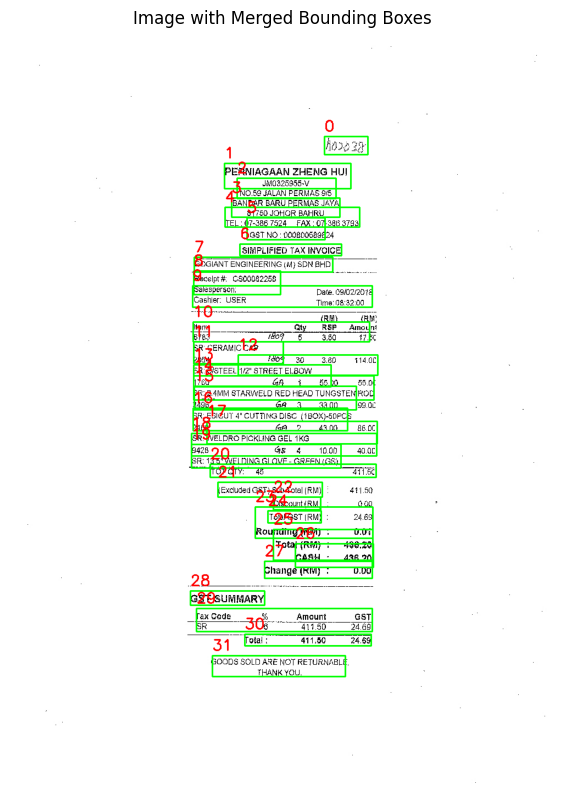


=== Text Detection Results ===
Number of merged boxes drawn: 32
Merged Box 0: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(572.0), np.float32(190.0), np.float32(651.0), np.float32(190.0), np.float32(651.0), np.float32(223.0), np.float32(572.0), np.float32(223.0)]
Merged Box 1: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(390.0), np.float32(239.0), np.float32(620.0), np.float32(239.0), np.float32(620.0), np.float32(285.0), np.float32(390.0), np.float32(285.0)]
Merged Box 2: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(413.0), np.float32(266.0), np.float32(593.0), np.float32(266.0), np.float32(593.0), np.float32(303.0), np.float32(413.0), np.float32(303.0)]
Merged Box 3: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(403.0), np.float32(302.0), np.float32(600.0), np.float32(302.0), np.float32(600.0), np.float32(337.0), np.float32(403.0), np.float32(337.0)]
Merged Box 4: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(391.0)

In [8]:
# Define input parameters
image_path = '/content/drive/MyDrive/OCR_Final/01.jpg'
model_path = '/content/drive/MyDrive/OCR_Final/frozen_east_text_detection.pb'
width = 960
height = 960
confThreshold = 0.7
nmsThreshold = 0.4
adaptive = False

# Run text detection
run_text_detection(image_path, model_path, width, height, confThreshold, nmsThreshold, adaptive)

**Ví dụ 2**

Độ phân giải ảnh: (1004, 439, 3)
Đã lưu ảnh kết quả tại: text_detection_result.jpg
Đã lưu tọa độ các hộp được vẽ tại: text_detection_boxes.csv


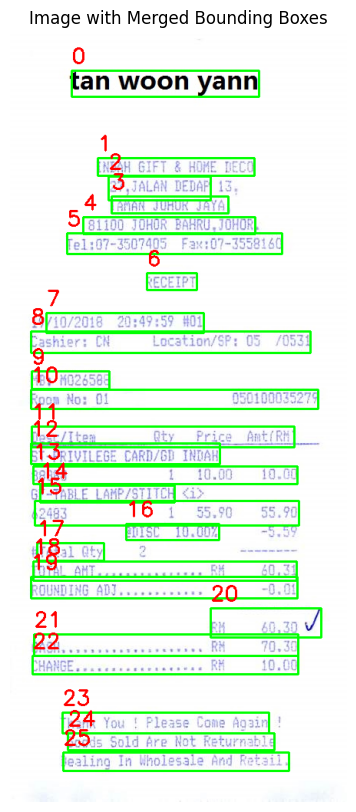


=== Text Detection Results ===
Number of merged boxes drawn: 26
Merged Box 0: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(80.0), np.float32(50.0), np.float32(324.0), np.float32(50.0), np.float32(324.0), np.float32(84.0), np.float32(80.0), np.float32(84.0)]
Merged Box 1: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(114.0), np.float32(164.0), np.float32(318.0), np.float32(164.0), np.float32(318.0), np.float32(187.0), np.float32(114.0), np.float32(187.0)]
Merged Box 2: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(128.0), np.float32(188.0), np.float32(261.0), np.float32(188.0), np.float32(261.0), np.float32(219.0), np.float32(128.0), np.float32(219.0)]
Merged Box 3: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(132.0), np.float32(214.0), np.float32(284.0), np.float32(214.0), np.float32(284.0), np.float32(236.0), np.float32(132.0), np.float32(236.0)]
Merged Box 4: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(95.0), np.fl

In [10]:
# Upload the input image
image_path = '/content/drive/MyDrive/OCR_Final/001.jpg'
model_path = '/content/drive/MyDrive/OCR_Final/frozen_east_text_detection.pb'

# Set parameters (replacing argparse)
width = 1280
height = 1280
confThreshold = 0.7
nmsThreshold = 0.4
adaptive = False  # Set to True if you want adaptive preprocessing

# Run text detection
run_text_detection(image_path, model_path, width, height, confThreshold, nmsThreshold, adaptive)

# Download the result image
# files.download('text_detection_result.png')

# Text Recognise

In [11]:
class CharTokenizer:
    def __init__(self):
        self.specials = ['<pad>', '<sos>', '<eos>']
        self.chars = (self.specials +
                      list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') +
                      list('àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ') +
                      list('0123456789') +
                      list(' .,?!:;-()[]{}"\'/'))
        self.char2idx = {c: i for i, c in enumerate(self.chars)}
        self.idx2char = {i: c for i, c in enumerate(self.chars)}
        self.pad_id = self.char2idx['<pad>']
        self.sos_id = self.char2idx['<sos>']
        self.eos_id = self.char2idx['<eos>']

    def __call__(self, text):
        return [self.char2idx.get(c, self.char2idx[' ']) for c in text]

    def decode(self, indices):
        chars = []
        for idx in indices:
            if idx == self.eos_id:
                break
            chars.append(self.idx2char.get(idx, ' '))
        return ''.join(chars)

In [12]:
class CNNBackbone(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.features = nn.Sequential(*list(backbone.features.children()))
        self.proj = nn.Linear(1280, d_model)
        self.d_model = d_model

    def forward(self, x):
        feat = self.features(x)
        feat = feat.flatten(2).transpose(1, 2)
        feat = self.proj(feat)
        return feat

class CustomTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, return_attention=False):
        tgt2, self_attn_weights = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)

        tgt2, cross_attn_weights = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm2(tgt)

        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)

        if return_attention:
            return tgt, self_attn_weights, cross_attn_weights
        return tgt

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=3, num_heads=4, d_ff=1024, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, d_model))
        self.transformer_layers = nn.ModuleList([
            CustomTransformerDecoderLayer(d_model, num_heads, d_ff, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model
        self.num_layers = num_layers

    def forward(self, tgt, memory, return_attention=False):
        B, T = tgt.size()
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = tgt_emb + self.pos_encoder[:, :T, :]

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(tgt.device)

        output = tgt_emb.transpose(0, 1)
        attn_weights = [] if return_attention else None

        for layer in self.transformer_layers:
            if return_attention:
                output, self_attn, cross_attn = layer(output, memory.transpose(0, 1),
                                                    tgt_mask=tgt_mask, return_attention=True)
                attn_weights.append(cross_attn)
            else:
                output = layer(output, memory.transpose(0, 1), tgt_mask=tgt_mask)

        output = output.transpose(0, 1)
        logits = self.fc_out(output)

        if return_attention:
            return logits, attn_weights
        return logits

class OCRModel(nn.Module):
    def __init__(self, vocab_size, max_len=100, pad_id=0, sos_id=1, eos_id=2):
        super().__init__()
        self.pad_id = pad_id
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.max_len = max_len
        self.encoder = CNNBackbone()
        self.decoder = TransformerDecoder(vocab_size, max_len=max_len)
        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

    def forward(self, images, tgt_seq=None, return_attention=False):
        memory = self.encoder(images)

        if tgt_seq is not None:
            if return_attention:
                logits, attn_weights = self.decoder(tgt_seq, memory, return_attention=True)
                loss = self.criterion(logits[:, :-1].reshape(-1, logits.size(-1)),
                                    tgt_seq[:, 1:].reshape(-1))
                return logits, loss, attn_weights
            else:
                logits = self.decoder(tgt_seq, memory)
                loss = self.criterion(logits[:, :-1].reshape(-1, logits.size(-1)),
                                    tgt_seq[:, 1:].reshape(-1))
                return logits, loss

        B = images.size(0)
        device = images.device
        generated = torch.full((B, 1), self.sos_id, dtype=torch.long, device=device)

        for _ in range(self.max_len - 1):
            logits = self.decoder(generated, memory)
            next_token = logits[:, -1].argmax(-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            if (next_token == self.eos_id).all():
                break

        if return_attention:
            _, attn_weights = self.decoder(generated, memory, return_attention=True)
            return generated[:, 1:], attn_weights
        return generated[:, 1:]

In [18]:
def preprocess_cropped_image(img, target_size=(85, 515)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size[::-1], interpolation=cv2.INTER_CUBIC)
    img_pil = Image.fromarray(img)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img_tensor = transform(img_pil)
    return img_tensor

def visualize_results(image, results, output_path, attn_weights=None):
    img = image.copy()

    # 1. Tạo và lưu ảnh dự đoán (Predicted Image)
    plt.figure(figsize=(8, 6), dpi=300)
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

    # Vẽ hộp và văn bản dự đoán
    for idx, result in enumerate(results):
        box = result['box']
        text = result['text']
        x_min, y_min, x_max, y_max = box

        color = colors[idx % len(colors)]
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)

        label = f"{text}"
        cv2.putText(img, label, (x_min, y_min - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(img, label, (x_min, y_min - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Hình ảnh với dự đoán', fontsize=14)
    plt.axis('off')

    # Lưu ảnh dự đoán
    pred_output_path = output_path.replace('.jpg', '_predicted.jpg')
    plt.tight_layout()
    plt.savefig(pred_output_path, bbox_inches='tight', dpi=300)
    plt.show()  # Hiển thị trong Colab
    plt.close()

    # 2. Tạo và lưu heatmap
    plt.figure(figsize=(8, 6), dpi=300)
    if attn_weights is not None and len(attn_weights) > 0:
        attn = attn_weights[-1].mean(dim=0).cpu().numpy()
        h, w = 85, 515
        feat_h, feat_w = int(np.ceil(h / 32)), int(np.ceil(w / 32))
        expected_src_len = feat_h * feat_w

        if attn.shape[1] == expected_src_len:
            attn = attn.mean(axis=0).reshape(feat_h, feat_w)
            attn_resized = cv2.resize(attn, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
            sns.heatmap(attn_resized, cmap='viridis', alpha=0.6, cbar=True)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=0.4)
            plt.title('Bản đồ nhiệt Attention', fontsize=14)
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, 'Không có bản đồ nhiệt',
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'Không có trọng số Attention',
                horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')

    # Lưu heatmap
    heatmap_output_path = output_path.replace('.jpg', '_heatmap.jpg')
    plt.tight_layout()
    plt.savefig(heatmap_output_path, bbox_inches='tight', dpi=300)
    # plt.show()  # Hiển thị trong Colab
    plt.close()

    return pred_output_path, heatmap_output_path

In [16]:
def test_single_image(model, tokenizer, image_path, box_path, output_dir, device='cuda'):
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load and validate image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể tải hình ảnh tại {image_path}")

    # Load and validate box coordinates
    if not os.path.exists(box_path):
        raise ValueError(f"Không tìm thấy file tọa độ tại {box_path}")

    df = pd.read_csv(box_path, quotechar='"', encoding='utf-8')
    required_cols = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']
    if df.empty or not all(col in df for col in required_cols):
        raise ValueError(f"Định dạng file tọa độ không hợp lệ tại {box_path}")

    results = []
    attention_weights_list = []

    # Process each bounding box
    for idx, row in df.iterrows():
        box_coords = [int(row['x1']), int(row['y1']),
                      int(row['x2']), int(row['y2']),
                      int(row['x3']), int(row['y3']),
                      int(row['x4']), int(row['y4'])]
        x_min, x_max = min(box_coords[::2]), max(box_coords[::2])
        y_min, y_max = min(box_coords[1::2]), max(box_coords[1::2])

        # Crop and preprocess image region
        cropped_img = img[y_min:y_max, x_min:x_max]
        if cropped_img.size == 0:
            print(f"Cảnh báo: Vùng cắt rỗng cho hộp {idx} trong {image_path}")
            continue

        img_tensor = preprocess_cropped_image(cropped_img).unsqueeze(0).to(device)

        # Run inference
        with torch.no_grad():
            generated, attn_weights = model(img_tensor, return_attention=True)

        pred_text = tokenizer.decode(generated[0].cpu().numpy())

        results.append({'box': [x_min, y_min, x_max, y_max], 'text': pred_text})
        attention_weights_list.append(attn_weights)

    # Save visualization (returns two paths)
    output_filename = f"result_{os.path.basename(image_path)}"
    output_path = os.path.join(output_dir, output_filename)
    pred_output_path, heatmap_output_path = visualize_results(img, results, output_path, attention_weights_list[0] if attention_weights_list else None)

    # Save predictions to a text file
    pred_txt_output_path = os.path.join(output_dir, f"predictions_{os.path.basename(image_path).replace('.jpg', '.txt').replace('.png', '.txt')}")
    with open(pred_txt_output_path, 'w', encoding='utf-8') as f:
        for idx, result in enumerate(results):
            f.write(f"Hộp {idx}: {result['text']}\n")

    print(f"Ảnh dự đoán đã lưu tại {pred_output_path}")
    print(f"Heatmap đã lưu tại {heatmap_output_path}")
    print(f"Dự đoán văn bản đã lưu tại {pred_txt_output_path}")
    print("Văn bản dự đoán:")
    for idx, result in enumerate(results):
        print(f"Hộp {idx}: {result['text']}")

    # # Tải xuống kết quả
    # print("Tải xuống kết quả...")
    # files.download(pred_output_path)
    # files.download(heatmap_output_path)
    # files.download(pred_txt_output_path)

    return results

**Ví dụ 1**

Đang xử lý ảnh: /content/drive/MyDrive/OCR_Final/001.jpg


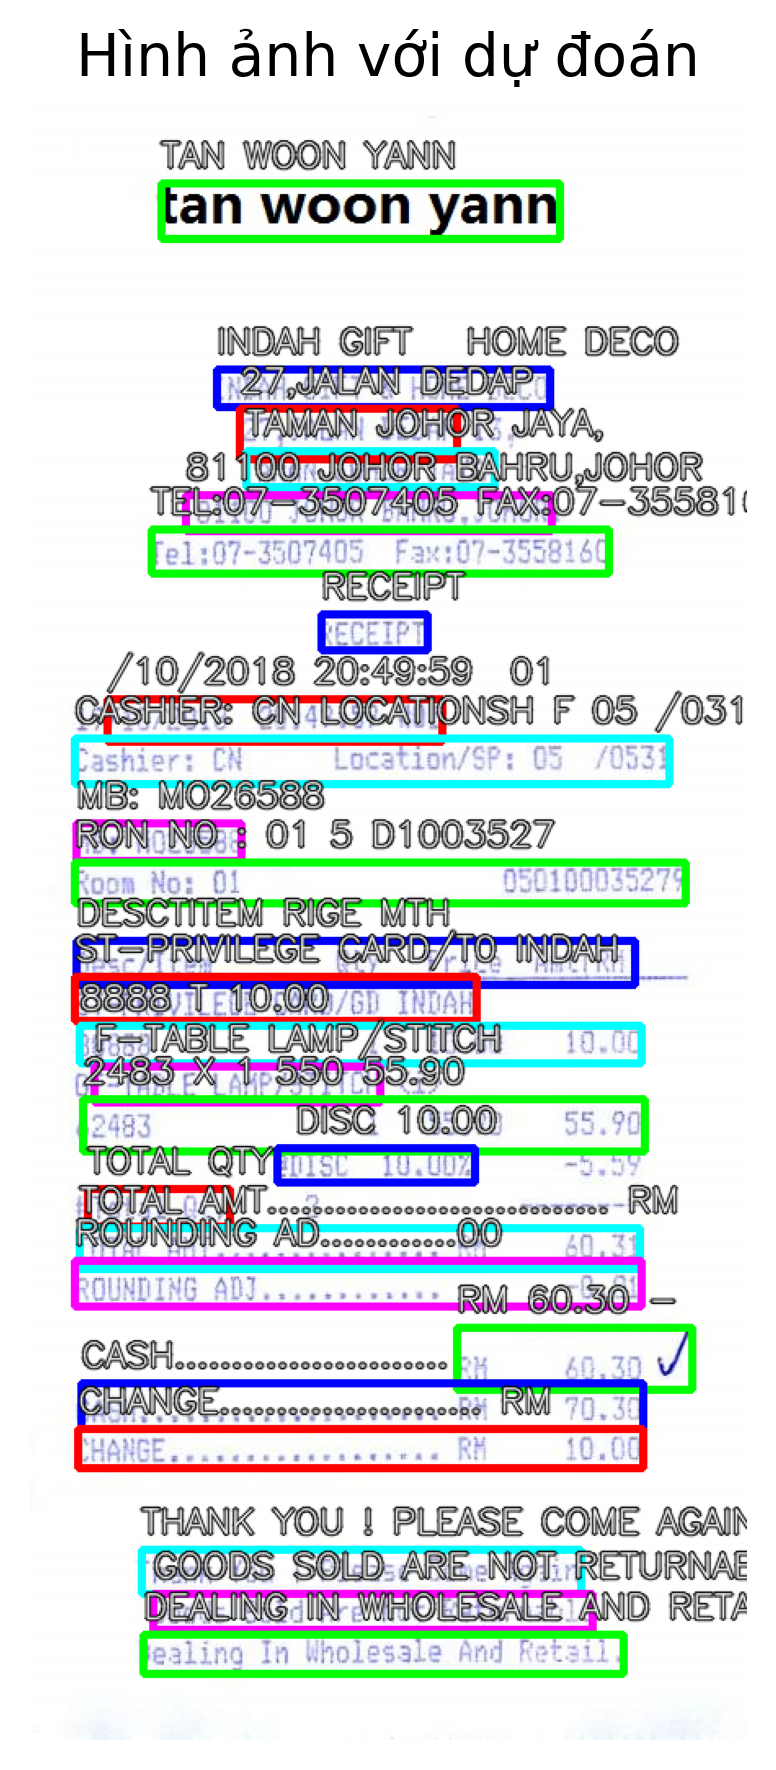

Ảnh dự đoán đã lưu tại /content/test_results/result_001_predicted.jpg
Heatmap đã lưu tại /content/test_results/result_001_heatmap.jpg
Dự đoán văn bản đã lưu tại /content/test_results/predictions_001.txt
Văn bản dự đoán:
Hộp 0: TAN WOON YANN
Hộp 1: INDAH GIFT   HOME DECO
Hộp 2: 27,JALAN DEDAP
Hộp 3: TAMAN JOHOR JAYA,
Hộp 4: 81100 JOHOR BAHRU,JOHOR
Hộp 5: TEL:07-3507405 FAX:07-3558160
Hộp 6: RECEIPT
Hộp 7: /10/2018 20:49:59  01
Hộp 8: CASHIER: CN LOCATIONSH F 05 /031
Hộp 9: MB: MO26588
Hộp 10: RON NO : 01 5 D1003527
Hộp 11: DESCTITEM RIGE MTH
Hộp 12: ST-PRIVILEGE CARD/T0 INDAH
Hộp 13: 8888 T 10.00
Hộp 14: F-TABLE LAMP/STITCH
Hộp 15: 2483 X 1 550 55.90
Hộp 16:  DISC 10.00 
Hộp 17: TOTAL QTY
Hộp 18: TOTAL AMT.............................. RM
Hộp 19: ROUNDING AD............00
Hộp 20: RM 60.30 -
Hộp 21: CASH........................
Hộp 22: CHANGE....................... RM
Hộp 23: THANK YOU ! PLEASE COME AGAIN
Hộp 24: GOODS SOLD ARE NOT RETURNABLE
Hộp 25: DEALING IN WHOLESALE AND RETAIL.


In [19]:
# Định nghĩa tham số
image_path = '/content/drive/MyDrive/OCR_Final/001.jpg'  # Thay bằng đường dẫn thực tế
box_path = '/content/text_detection_boxes.csv'  # File CSV từ hàm run_text_detection
model_path = '/content/drive/MyDrive/OCR_Final/best_model.pt'  # Thay bằng đường dẫn thực tế
output_dir = '/content/test_results'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Tạo thư mục đầu ra
os.makedirs(output_dir, exist_ok=True)

# Khởi tạo tokenizer và model
tokenizer = CharTokenizer()
model = OCRModel(vocab_size=len(tokenizer.chars),
                 pad_id=tokenizer.pad_id,
                 sos_id=tokenizer.sos_id,
                 eos_id=tokenizer.eos_id)

# Tải trọng số mô hình
if not os.path.exists(model_path):
    raise ValueError(f"Checkpoint mô hình không tìm thấy tại {model_path}")
model.load_state_dict(torch.load(model_path, map_location='cpu'))

# Chạy suy luận
print(f"Đang xử lý ảnh: {image_path}")
results = test_single_image(model, tokenizer, image_path, box_path, output_dir, device)

**Ví dụ 2**

Độ phân giải ảnh: (960, 720, 3)
Đã lưu ảnh kết quả tại: text_detection_result.jpg
Đã lưu tọa độ các hộp được vẽ tại: text_detection_boxes.csv


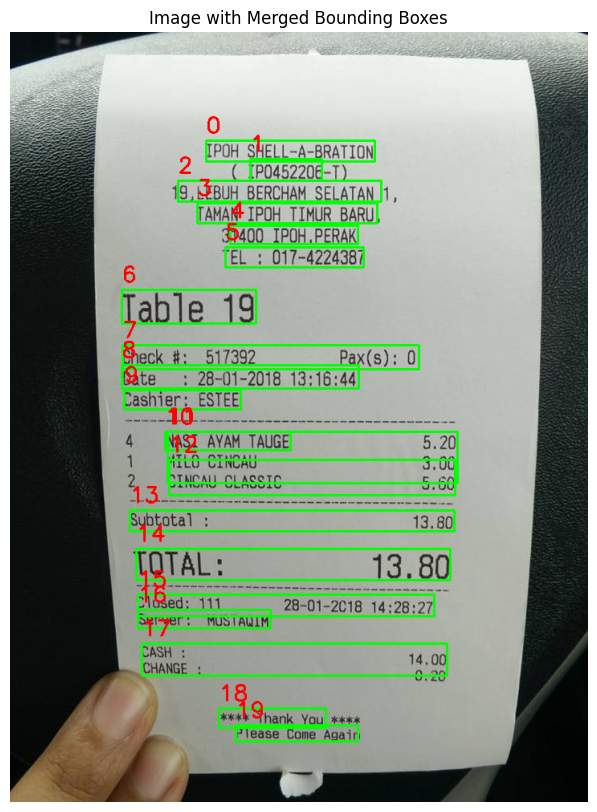


=== Text Detection Results ===
Number of merged boxes drawn: 20
Merged Box 0: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(244.0), np.float32(135.0), np.float32(454.0), np.float32(135.0), np.float32(454.0), np.float32(161.0), np.float32(244.0), np.float32(161.0)]
Merged Box 1: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(299.0), np.float32(158.0), np.float32(388.0), np.float32(158.0), np.float32(388.0), np.float32(185.0), np.float32(299.0), np.float32(185.0)]
Merged Box 2: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(209.0), np.float32(185.0), np.float32(462.0), np.float32(185.0), np.float32(462.0), np.float32(211.0), np.float32(209.0), np.float32(211.0)]
Merged Box 3: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(233.0), np.float32(213.0), np.float32(457.0), np.float32(213.0), np.float32(457.0), np.float32(238.0), np.float32(233.0), np.float32(238.0)]
Merged Box 4: Coordinates [x1, y1, x2, y2, x3, y3, x4, y4] = [np.float32(274.0)

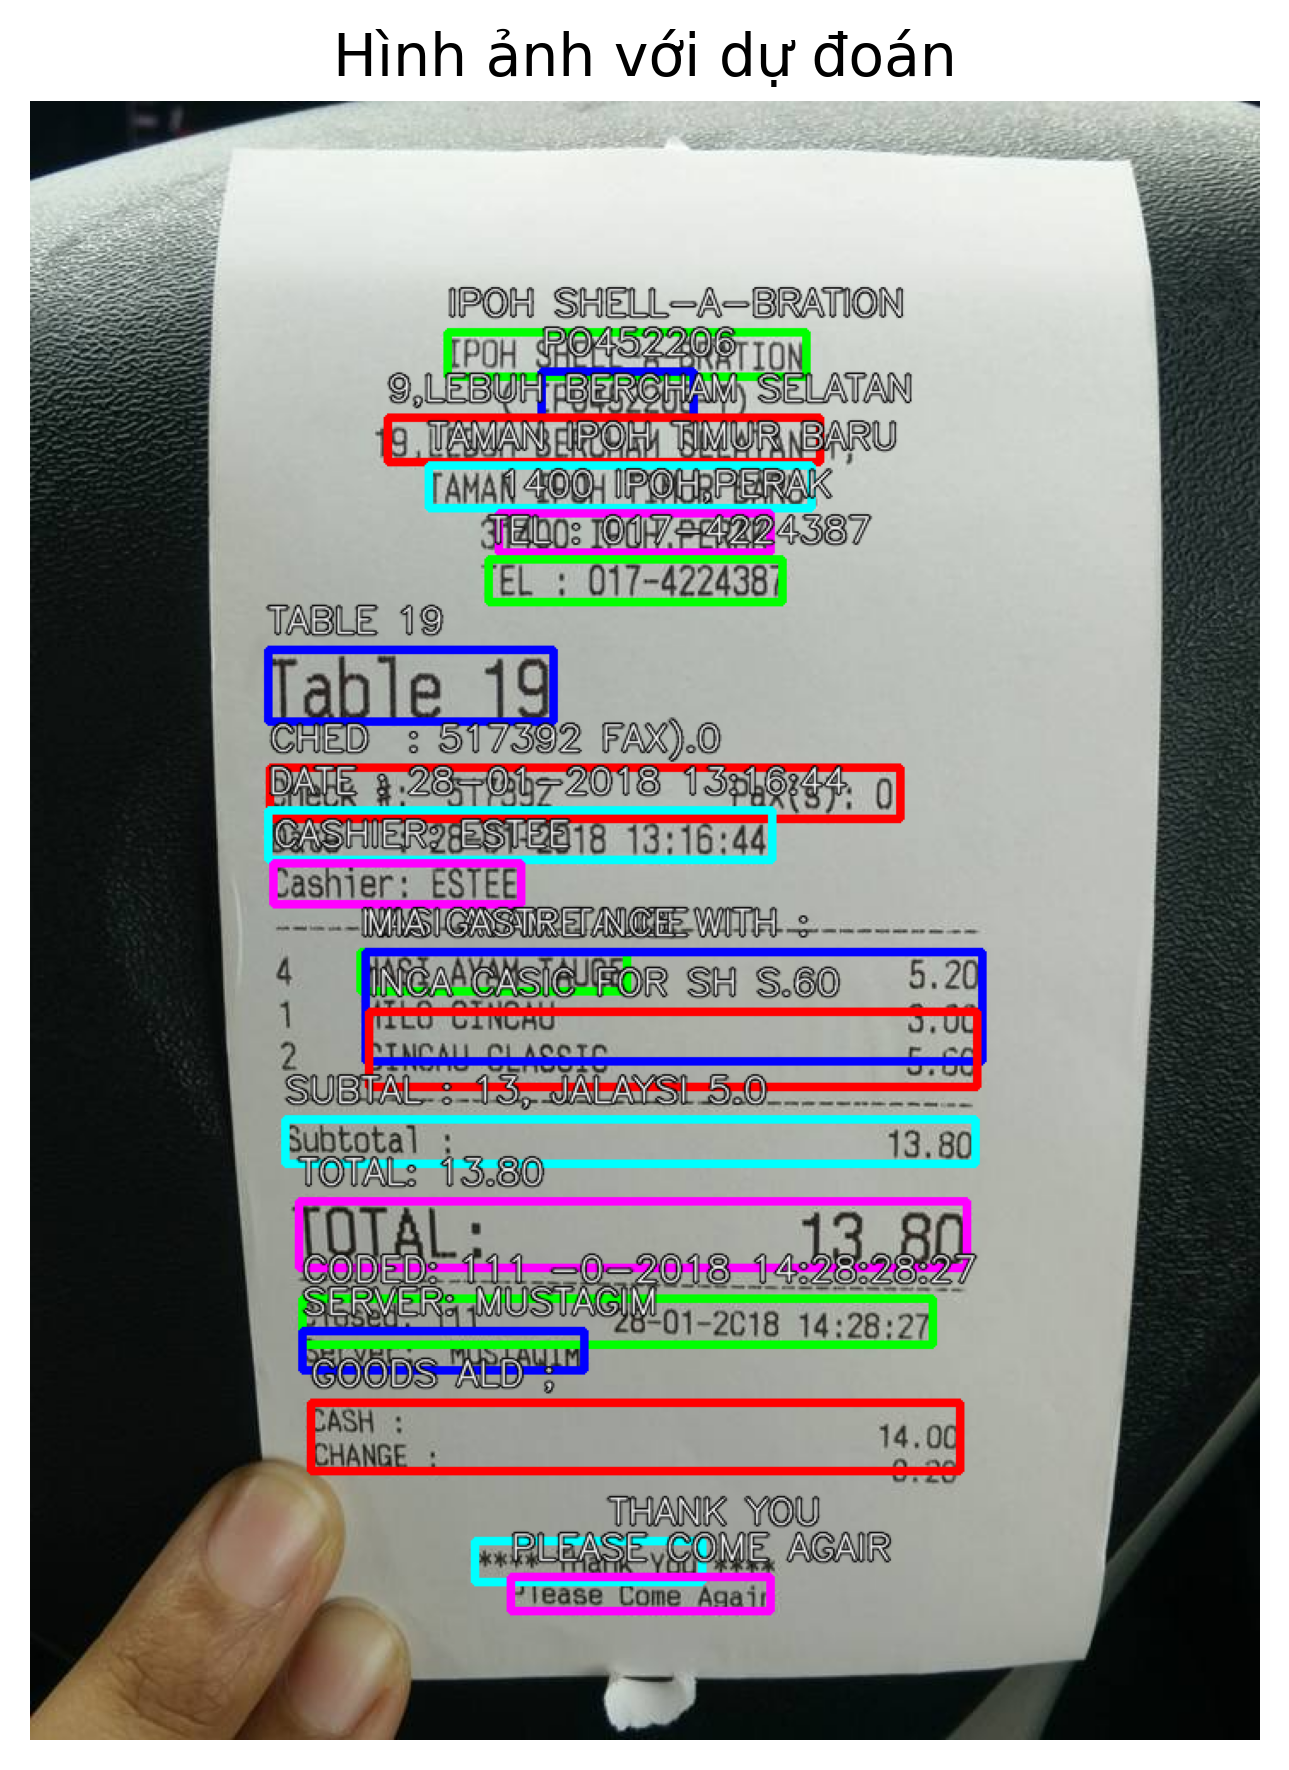

Ảnh dự đoán đã lưu tại /content/test_results/result_3dfc_predicted.jpg
Heatmap đã lưu tại /content/test_results/result_3dfc_heatmap.jpg
Dự đoán văn bản đã lưu tại /content/test_results/predictions_3dfc.txt
Văn bản dự đoán:
Hộp 0: IPOH SHELL-A-BRATION
Hộp 1: PO452206
Hộp 2: 9,LEBUH BERCHAM SELATAN
Hộp 3: TAMAN IPOH TIMUR BARU
Hộp 4: 1400 IPOH,PERAK
Hộp 5: TEL : 017-4224387
Hộp 6: TABLE 19
Hộp 7: CHED  : 517392 FAX).0
Hộp 8: DATE : 28-01-2018 13:16:44
Hộp 9: CASHIER: ESTEE
Hộp 10: NASI AYAM TAUGE
Hộp 11: MIA GASTRE NCE WITH :
Hộp 12: INCA CASIC FOR SH S.60
Hộp 13: SUBTAL : 13, JALAYSI 5.0
Hộp 14: TOTAL: 13.80
Hộp 15: CODED: 111 -0-2018 14:28:28:27
Hộp 16: SERVER: MUSTAGIM
Hộp 17: GOODS ALD ;
Hộp 18:        THANK YOU
Hộp 19: PLEASE COME AGAIR


In [23]:
# Định nghĩa tham số
image_path = '/content/3dfc.jpg'
model_path_detection = '/content/drive/MyDrive/OCR_Final/frozen_east_text_detection.pb'
box_path = '/content/text_detection_boxes.csv'  # File CSV từ hàm run_text_detection
model_path_recognise = '/content/drive/MyDrive/OCR_Final/best_model.pt'  # Thay bằng đường dẫn thực tế
output_dir = '/content/test_results'
width = 960
height = 960
confThreshold = 0.7
nmsThreshold = 0.4
adaptive = False  # Set to True if you want adaptive preprocessing

# Chạy text detection
run_text_detection(image_path, model_path_detection, width, height, confThreshold, nmsThreshold, adaptive)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Tạo thư mục đầu ra
os.makedirs(output_dir, exist_ok=True)

# Khởi tạo tokenizer và model
tokenizer = CharTokenizer()
model = OCRModel(vocab_size=len(tokenizer.chars),
                 pad_id=tokenizer.pad_id,
                 sos_id=tokenizer.sos_id,
                 eos_id=tokenizer.eos_id)

# Tải trọng số mô hình
if not os.path.exists(model_path_recognise):
    raise ValueError(f"Checkpoint mô hình không tìm thấy tại {model_path_recognise}")
model.load_state_dict(torch.load(model_path, map_location='cpu'))

# Chạy suy luận
print(f"Đang xử lý ảnh: {image_path}")
results = test_single_image(model, tokenizer, image_path, box_path, output_dir, device)

# So sánh thử với mô hình EasyOCR

**Cài đặt mô hình EasyOCR**

In [24]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 24.4 MB/s eta 0:00:00


Saving 3dfc.jpg to 3dfc (1).jpg
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteText: IPOH SHELL-A-BRATION, Confidence: 0.82
Text: IP0452206-T), Confidence: 0.49
Text: 19 , LEBUH BERCHAM SELATAN 1, Confidence: 0.32
Text: TAMAN IPOH TIMUR BARU ,, Confidence: 0.70
Text: 31400 IPOH , PERAK, Confidence: 0.65
Text: TEL, Confidence: 1.00
Text: 017-4224387, Confidence: 1.00
Text: Table 19, Confidence: 0.64
Text: Check #:, Confidence: 0.80
Text: 517392, Confidence: 1.00
Text: Pax(s) :, Confidence: 0.69
Text: 0, Confidence: 1.00
Text: Date, Confidence: 1.00
Text: 28-01-2018 13;16:44, Confidence: 0.66
Text: Cashier: ESTEE, Confidence: 0.79
Text: NASI AYAM TAUGE, Confidence: 0.73
Text: 5.20, Confidence: 1.00
Text: MILO CINCAU, Confidence: 0.97
Text: 3.00, Confidence: 0.72
Text: 2, Confidence: 1.00
Text: CINCAU CLASSIC, Confidence: 0.72
Text: 5.60, Confidence: 1.00
Text: Subtota], Confidence: 0.93
Text: 13.80, Confidence: 0.99
Text: TOTAL:, Confidence: 1.00
Text: 13.80, Confidence: 0.64
Text: closed

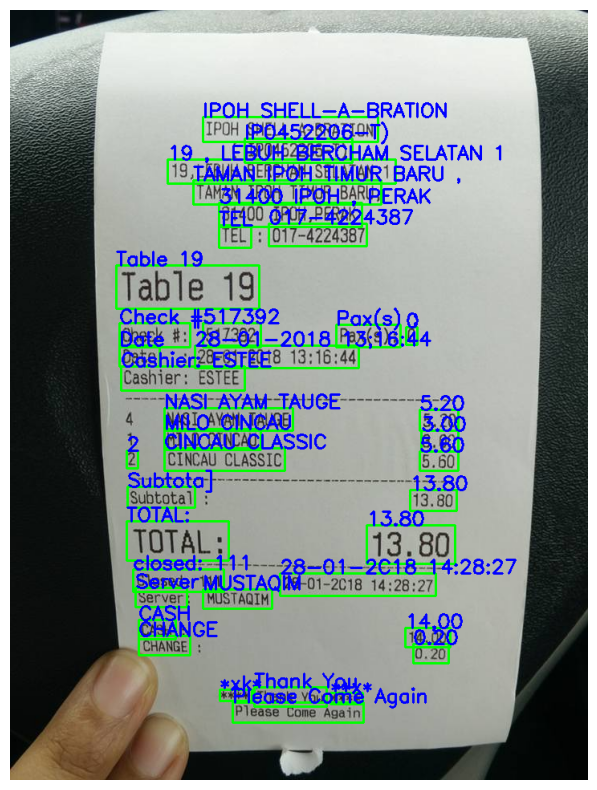

In [25]:
import easyocr

# Upload ảnh
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Đọc ảnh
image = cv2.imread(image_path)

# Khởi tạo EasyOCR với tiếng Việt và tiếng Anh
reader = easyocr.Reader(['vi', 'en'], gpu=True)  # gpu=True để dùng GPU

# Chạy OCR
results = reader.readtext(image)

# In kết quả
for (bbox, text, prob) in results:
    print(f"Text: {text}, Confidence: {prob:.2f}")

# Vẽ bounding box lên ảnh
for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()